In [20]:
import os
import warnings
import json
from google.cloud import storage
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset, Dataset
import torch
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from tqdm import tqdm
import re
import gcsfs
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
import matplotlib.pyplot as plt
from google.cloud import storage, bigquery
from datasets import concatenate_datasets
from collections import Counter
import seaborn as sns
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/mnt/disks/data/diss_bucket_key.json"
# Turn off all warnings
warnings.filterwarnings('ignore')

In [21]:
os.environ["HF_DATASETS_CACHE"] = "/mnt/disks/data/hf_cache"
os.environ["HF_DATASETS_OFFLINE"] = "1"  # Optional: if you're only working locally
os.environ["TRANSFORMERS_CACHE"] = "/mnt/disks/data/transformers_cache"
os.environ["TMPDIR"] = "/mnt/disks/data/tmp"

In [22]:
# Detect number of GPUs
gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {gpus}")
print(torch.cuda.get_device_name(0))
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

Number of GPUs available: 1
NVIDIA A100-SXM4-40GB


In [23]:
# === Configuration ===
MODEL_LOCAL_DIR = "./deberta_news"
PROJECT_ID = "bamboo-mercury-462915-f0"
BQ_DATASET = "edgar_sentiment"
BQ_TABLE = "news_scores_overlap"
REGION = "europe-west2"
OUTPUT_DIR = f"gs://diss_market_data/finbert-finetune-output"
# MODEL_NAME = "yiyanghkust/finbert-tone"
NUM_LABELS = 3

In [24]:
# === Extract data from BigQuery for training ===
bq_client = bigquery.Client()
query = f"""(SELECT article, sentiment_score, sentiment_label FROM `{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE}`
        where sentiment_label IN ('Positive', 'Neutral'))
        UNION ALL
        (SELECT article, sentiment_score, sentiment_label FROM `{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE}`
        where sentiment_label IN ('Negative') LIMIT 4500)
        """
df_news = bq_client.query(query).to_dataframe()
print(f"Retrieved {len(df_news)} rows from filings training table {BQ_DATASET}.{BQ_TABLE}")

Retrieved 12667 rows from filings training table edgar_sentiment.news_scores_overlap


In [25]:
# === Environment Variables for HPC ===
os.environ["GOOGLE_CLOUD_PROJECT"] = PROJECT_ID
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "dryrun"
os.environ["NCCL_DEBUG"] = "INFO"
os.environ["NCCL_P2P_DISABLE"] = "1"

In [26]:
# Gemini Labeled Filings in chunks
label_map = {"Negative": 2, "Neutral": 0, "Positive": 1}
df_news['label'] = df_news['sentiment_label'].map(label_map)
df1 = df_news[['article', 'label']].rename(columns={'article': 'text'})
df_final = pd.concat([df1])

In [27]:
# 1. Create a single Hugging Face Dataset from df_final
ds = Dataset.from_pandas(df_final[['text', 'label']], preserve_index=False)

# 2. Split into train/test (here 80% train, 20% eval)
split = ds.train_test_split(test_size=0.2, seed=42, shuffle=True)

# 3. Assign
train_dataset_temp = split['train']
eval_dataset  = split['test']

In [28]:
df = eval_dataset.to_pandas()

In [29]:
df.head()

,text,label
0,telephones are national and regulators were co...,2
1,"dighton capital management, a geneva - based h...",1
2,demand for oil tankers will match supply by th...,1
3,"show. thai oil pcl has hired barclays plc, hsb...",0
4,"00056, and u. s. v. jiau, 11 - cr - 00161, u. ...",2


In [ ]:
human_eval_df = (
    df.groupby("label", group_keys=False)
      .apply(lambda x: x.sample(n=45, random_state=42))
)

print(human_eval_df["label"].value_counts())
# -- Saving the file to review --
human_eval_df.to_csv("news_human_eval.csv", index=False)

label
0    45
1    45
2    45
Name: count, dtype: int64


In [31]:
# ------------------------ Load Model -----------------------------
tokenizer = AutoTokenizer.from_pretrained(MODEL_LOCAL_DIR)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_LOCAL_DIR).to(DEVICE)
model.eval()

DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): Dropout(p=0.1, inplace=False)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

In [32]:
# ------------------------ Tokenize ------------------------
texts = human_eval_df["text"].tolist()
labels = human_eval_df["label"].tolist()

encodings = tokenizer(
    texts,
    truncation=True,
    padding=True,
    max_length=256,
    return_tensors="pt"
)

input_ids = encodings["input_ids"]
attention_mask = encodings["attention_mask"]
labels_tensor = torch.tensor(labels)

dataset = TensorDataset(input_ids, attention_mask, labels_tensor)
loader = DataLoader(dataset, batch_size=16)

In [33]:
# ------------------------ Evaluate ------------------------
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in loader:
        input_ids_batch, attention_mask_batch, labels_batch = [b.to(DEVICE) for b in batch]

        outputs = model(input_ids=input_ids_batch, attention_mask=attention_mask_batch)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())

In [34]:
# ------------------------ Metrics ------------------------
print("Accuracy:", accuracy_score(all_labels, all_preds))
print("Weighted F1: {:.3f}".format(f1_score(all_labels, all_preds, average="weighted")))
print(classification_report(all_labels, all_preds, digits=4))

Accuracy: 0.8518518518518519
Weighted F1: 0.850
              precision    recall  f1-score   support

           0     0.8500    0.7556    0.8000        45
           1     0.8444    0.8444    0.8444        45
           2     0.8600    0.9556    0.9053        45

    accuracy                         0.8519       135
   macro avg     0.8515    0.8519    0.8499       135
weighted avg     0.8515    0.8519    0.8499       135



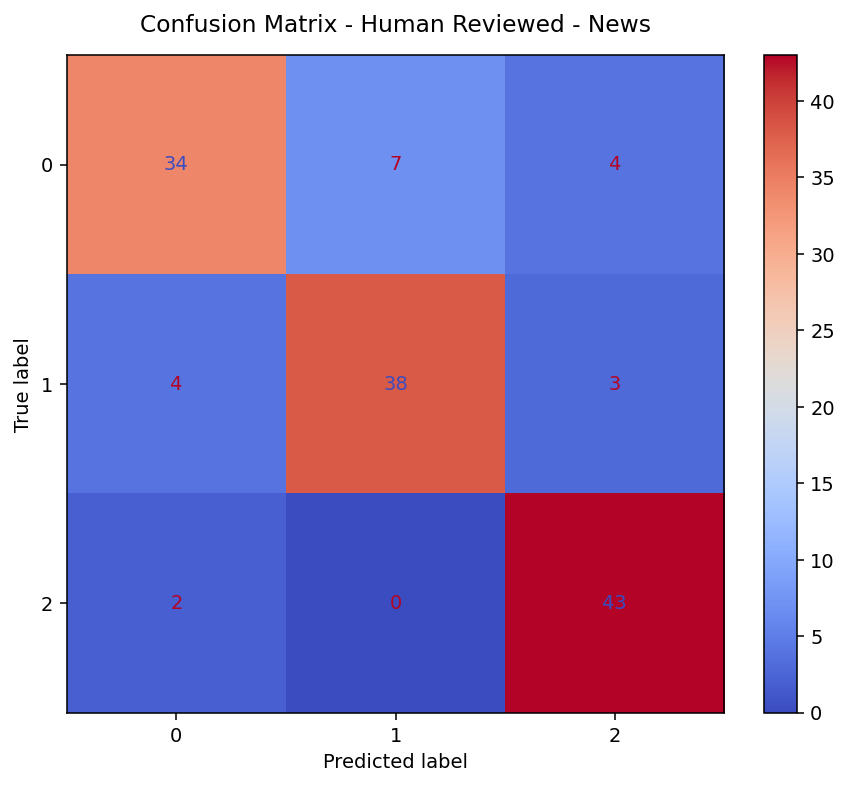

'confusion_matrix_human_reviewed_news.png'

In [39]:
# ------------------ Confusion Matrix ------------------
cm = confusion_matrix(all_labels, all_preds)
labels_sorted = sorted(set(labels))  # [0, 1, 2]

def plot_cm(cm_mat, labels, title, normalised=False, cmap_name="coolwarm",
            savepath=None, show=True, dpi=300):
    fig, ax = plt.subplots(figsize=(6.5, 5.5), dpi=140, constrained_layout=True)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_mat, display_labels=labels)
    disp.plot(ax=ax, cmap=cmap_name, colorbar=True,
              values_format=".2f" if normalised else "d")

    ax.set_title(title, pad=12)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.tick_params(axis="x", labelrotation=0)

    # Auto filename if none provided
    if savepath is None:
        base = re.sub(r"[^A-Za-z0-9_.-]+", "_", title.strip().lower())
        suffix = "_normalised" if normalised else ""
        savepath = f"{base}{suffix}.png"

    # Save BEFORE showing
    fig.savefig(savepath, dpi=dpi, bbox_inches="tight", pad_inches=0.1)

    if show:
        plt.show()

    plt.close(fig)
    return savepath

plot_cm(cm, labels_sorted, "Confusion Matrix - Human Reviewed - News",
        normalised=False, savepath="confusion_matrix_human_reviewed_news.png")